# Image Registration (SuperTomo2) 

In [10]:
import sys
import os
import supertomo.data.containers.image_data as image_data
import supertomo.ui.supertomo_options as supertomo_options
from supertomo.processing.registration.registration_mv import MultiViewRegistration

def open_data_file(path):
    
    if not path.endswith(".hdf5"):
        raise ValueError("Please specify a HDF5 data file")
    if not os.path.exists(path):
        raise ValueError("The specified file %s does not exist" % path)

    return image_data.ImageData(path)


## Datafile

All the image data from a tomographic imaging experiment is contained within a single *hdf5* file in SuperTomo2. The *supertomo1_hela.hdf5* contains the HeLa cell images from (Koho et al. 2015)

*Koho, S., T. Deguchi, and P. E. E. Hänninen. 2015. “A Software Tool for Tomographic Axial Superresolution in STED Microscopy.” Journal of Microscopy 260 (2): 208–18.*

In [11]:
working_directory = "/Users/sami/Documents/Work/Data/2018_05_FSC_paper"
file_name = "supertomo1_hela.hdf5"
full_path = os.path.join(working_directory, file_name)


data = open_data_file(full_path)

## Command line arguments

Most of the SuperTomo2 main functions have been implemented as command line scripts that have a rich command line argument interface to fine tune the behavior. Here the command line interface is not used, but I will use the same parameters to set the behavior of the image registration task.

The image registration will be performed with [Normalized Cross Correlation similarity metric](http://www.itk.org/Doxygen/html/classitk_1_1CorrelationImageToImageMetricv4.html), with sampling percentage set to 0.01%. Intensity threshold based spatial masking will be used to exclude dark regions from the metric calculation. 

The registration will proceed until either max. number of iterations or minimum optimizer step size (0.5nm) is reached. There are also other parameters that are left at default values here.

In [12]:
args_list = [file_name, "--dir={}".format(working_directory), "--sampling-percentage=.01",
             "--reg-relax-factor=.8", "--learning-rate=1", "--min-step=0.0005", "--reg-max-iterations=300", 
             "--set-rot-axis=0", "--scale=100", "--reg-method=correlation", "--mask-threshold=10",
             "--reg-enable-observers"]

options = supertomo_options.get_register_script_options(args_list)


## Registration

The **MultiViewRegistration** script iteratively registeres each projection in the data file with the reference image (which is the one at angle 0, typically the regular STED image). In the current dataset there is only one image pair, so the registration will terminate after the two views are successfully aligned. 

Initializing registration
Starting registration of views 0 (fixed) & 1 (moving)
Final metric value: -0.489886009013
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Gradient magnitude tolerance met after 84 iterations. Gradient magnitude (9.10237e-05) is less than gradient magnitude tolerance (0.0001).
itk::simple::AffineTransform
 AffineTransform (0x7fa65e9c2530)
   RTTI typeinfo:   itk::AffineTransform<double, 3u>
   Reference Count: 1
   Modified Time: 7346685
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     0.998944 0.0130857 0.0478457 
     0.0117005 0.680599 -0.637479 
     -0.0316951 0.750383 0.764201 
   Offset: [-0.222367, 6.07648, -3.64105]
   Center: [12.4111, 11.3274, 2.4112]
   Translation: [0.0281212, 1.06664, 3.89688]
   Inverse: 
     0.999454 0.0259281 -0.040946 
     0.0112745 0.765666 0.637995 
     0.0303815 -0.750746 0.680398 
   Singular: 0



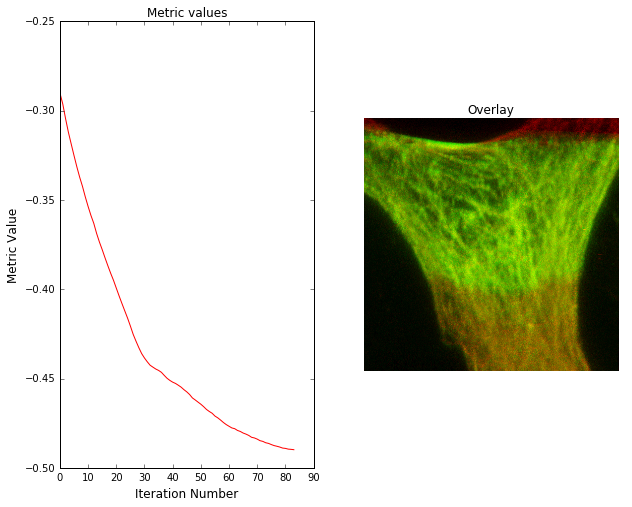

In [13]:
task = MultiViewRegistration(data, options)
task.set_fixed_image(0)
task.set_moving_image(1)

if not data.check_if_exists("registered", 0, options.channel, options.scale):
    data.set_active_image(0, options.channel, options.scale, "original")
    spacing = data.get_voxel_size()
    data.add_registered_image(data[:], options.scale, 0, options.channel,
                              0, spacing)

if not data.check_if_exists("registered", 1, options.channel, options.scale):
    task.execute()
    task.save_result()
    
else:
    print "Registration result for view {} already exists in the data structure.".format(1)


In [14]:
data.close()